<h1 style="text-align: center">Solving the N-Queens Problem with Genetic Programming</h1>

<hr style="border-top: 2px solid #444">

## Development Environment

### Python Dependencies

In [1]:
#!pip install -r pipenv-requirements.txt
#!pipenv install

### Python Imports

In [2]:
import sys
import random
import math
import deap
import numpy
import pandas
import matplotlib.pyplot as pyplot
from deap import algorithms, base, creator, tools
from IPython.display import display
from typing import List, Tuple, Callable, TypeVar

print(f"Python version: {sys.version}")
print(f"DEAP version: {deap.__version__}")
print(f"Numpy version: {numpy.__version__}")
print(f"Pandas: {pandas.__version__}")

Python version: 3.8.5 (tags/v3.8.5:580fbb0, Jul 20 2020, 15:57:54) [MSC v.1924 64 bit (AMD64)]
DEAP version: 1.3
Numpy version: 1.19.2
Pandas: 1.1.2


### Configure PRNG Seed

In [3]:
random.seed(42)

### Configure Pandas

In [4]:
pandas.set_option('display.max_rows', None)
pandas.set_option('display.max_columns', None)
pandas.set_option('display.width', None)
pandas.set_option('display.max_colwidth', None)

### Helper Methods

### Register DEAP Toolbox

In [5]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

T = TypeVar('T')
def evolution(*,
      individual_generator: Callable[[], T],
      fitness_evaluation: Callable[[T], float],
      population_size: int,
      generations: int,
      crossover_rate: float,
      mutation_rate: float,
      mutation_function: Tuple[Callable, dict],
):
    toolbox = base.Toolbox()

    # register population generators
    toolbox.register("individual", tools.initIterate, creator.Individual, individual_generator)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # register fitness evaluation function
    toolbox.register("evaluate", lambda individual: (fitness_evaluation(individual),))

    # register possible genetic mutations
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", mutation_function[0], **mutation_function[1])
    toolbox.register("select", tools.selTournament, tournsize=4)

    # generation statistics logging
    stats = tools.Statistics(key=lambda individual: individual.fitness.values)
    stats.register("min", lambda population: numpy.min([fitness for fitness in population if fitness[0] != math.inf]))
    stats.register("avg", lambda population: numpy.mean([fitness for fitness in population if fitness[0] != math.inf]))
    stats.register("max", lambda population: numpy.max([fitness for fitness in population if fitness[0] != math.inf]))

    # log fittest individual with a hall of fame record
    hall_of_fame = tools.HallOfFame(maxsize=1)

    # run genetic algorithm
    _, log = algorithms.eaSimple(
        # generate all individuals in population
        toolbox.population(n=population_size),
        toolbox,
        ngen=generations,
        cxpb=crossover_rate, mutpb=mutation_rate,
        stats=stats, halloffame=hall_of_fame, verbose=False,
    )

    # return statistics log and the fittest individual
    return log, hall_of_fame[0]

#### Visualization Plotter

In [6]:
def plot_generations(generation: List[int], average: List[float], minimum: List[int], maximum: List[int]):
    pyplot.figure(figsize=(16, 8))
    pyplot.grid(True)
    pyplot.plot(generation, average, label="average")
    pyplot.plot(generation, minimum, label="minimum")
    pyplot.plot(generation, maximum, label="maximum")
    pyplot.xlabel("Generation")
    pyplot.ylabel("Fitness")
    pyplot.ylim(-1)
    pyplot.legend(loc="upper right")
    pyplot.show()

<hr style="border-top: 2px solid #444">

## I. Position-index Board Encoding
- For an 8x8 board, there are (8^2)^8 possible states: 281,474,976,710,656
- For an 16x16 board, there are (16^2)^16 possible states: 340,282,366,920,938,463,463,374,607,431,768,211,456

### Rendering Positional Board

In [7]:
def display_positional_grid(individual: List[int]):
    # unpack dimensions
    dimension = len(individual)

    # construct board using pandas
    board = pandas.DataFrame("", index = range(dimension), columns = range(dimension))

    # draw all conflicts with a red line
    for x in range(len(individual)):
        x_row, x_column = individual[x] // dimension, individual[x] % dimension
        for y in range(x + 1, len(individual)):
            y_row, y_column = individual[y] // dimension, individual[y] % dimension

            diff_row, diff_column = y_row - x_row, y_column - x_column
            # check if queens are conflicting
            if x_row == y_row or x_column == y_column or abs(diff_row) == abs(diff_column):
                # draw a line of the conflict
                for i in range(1 + max(abs(diff_row), abs(diff_column))):
                    board[x_column + i * numpy.sign(diff_column)][x_row + i * numpy.sign(diff_row)] = "🟥"

    # draw all queens
    for queen in individual:
        row, column = queen // dimension, queen % dimension
        # use a crown if
        board[column][row] = "👑" if board[column][row] == "" else "♕"

    # render board with pandas
    display(board)

### Example 8x8 Individual

In [8]:
example_individual = random.sample(range(8**2), 8)
print(f"Positions: {example_individual}")
print(f"Duplicate positions: {len(example_individual) - len(set(example_individual))}")
display_positional_grid(example_individual)

Positions: [14, 1, 47, 17, 15, 63, 8, 61]
Duplicate positions: 0


,0,1,2,3,4,5,6,7
0,,♕,,,,,,
1,♕,🟥,🟥,🟥,🟥,🟥,♕,♕
2,,♕,,,,,,🟥
3,,,,,,,,🟥
4,,,,,,,,🟥
5,,,,,,,,♕
6,,,,,,,🟥,🟥
7,,,,,,♕,🟥,♕


### Fitness Function
Time complexity: `O(|queens|^2)`

In [9]:
def evaluate_position_indexed_fitness(individual: List[int]) -> float:
    # duplicate values should be removed with the severest penalty
    if len(individual) != len(set(individual)):
        return math.inf

    # unpack dimensions
    dimension = len(individual)
    # count all pairs of conflicts
    fitness: float = 0
    for x in range(len(individual)):
        x_row, x_column = individual[x] // dimension, individual[x] % dimension
        for y in range(x + 1, len(individual)):
            y_row, y_column = individual[y] // dimension, individual[y] % dimension
            if x_row == y_row or x_column == y_column or abs(x_row - y_row) == abs(x_column - y_column):
                fitness += 1
    return fitness

### Evolutionary Algorithm on a 8x8 Board

#### Evolutionary Computation

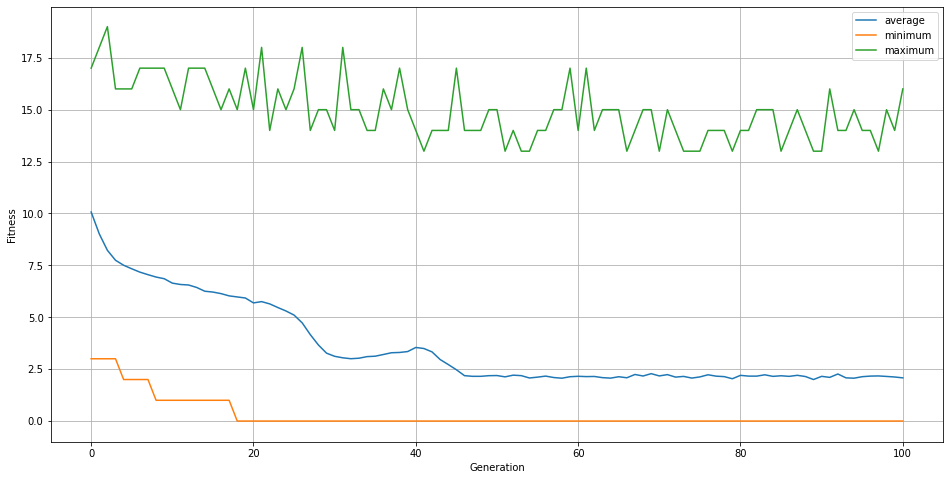

In [10]:
log, fittest_individual_p8 = evolution(
    individual_generator=lambda: random.choices(range(8**2), k=8),
    fitness_evaluation=evaluate_position_indexed_fitness,
    population_size=2500,
    generations=100,
    crossover_rate=.5,
    mutation_rate=.5,
    mutation_function=(tools.mutUniformInt, {"low": 0, "up": 8**2 - 1, "indpb": .25})
)
plot_generations(*log.select("gen", "avg", "min", "max"))

#### Fittest Individual

In [11]:
print(f"Positions: {fittest_individual_p8}")
print(f"Duplicate positions: {len(fittest_individual_p8) - len(set(fittest_individual_p8))}")
print(f"Fitness: {abs(fittest_individual_p8.fitness.values[0])}")
display_positional_grid(fittest_individual_p8)

Positions: [24, 44, 7, 9, 38, 61, 50, 19]
Duplicate positions: 0
Fitness: 0.0


,0,1,2,3,4,5,6,7
0,,,,,,,,👑
1,,👑,,,,,,
2,,,,👑,,,,
3,👑,,,,,,,
4,,,,,,,👑,
5,,,,,👑,,,
6,,,👑,,,,,
7,,,,,,👑,,


### Evolutionary Algorithm on a 16x16 Board

#### Evolutionary Computation

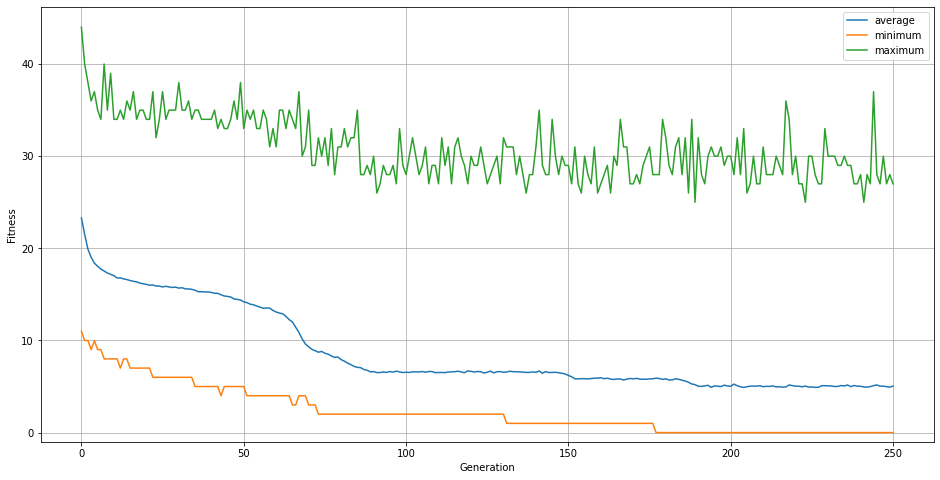

In [12]:
log, fittest_individual_p16 = evolution(
    individual_generator=lambda: random.choices(range(16**2), k=16),
    fitness_evaluation=evaluate_position_indexed_fitness,
    population_size=10000,
    generations=250,
    crossover_rate=.5,
    mutation_rate=.5,
    mutation_function=(tools.mutUniformInt, {"low": 0, "up": 16**2 - 1, "indpb": .25})
)
plot_generations(*log.select("gen", "avg", "min", "max"))

#### Fittest Individual

In [13]:
print(f"Positions: {fittest_individual_p16}")
print(f"Duplicate positions: {len(fittest_individual_p16) - len(set(fittest_individual_p16))}")
print(f"Fitness: {abs(fittest_individual_p16.fitness.values[0])}")
display_positional_grid(fittest_individual_p16)

Positions: [80, 251, 209, 150, 188, 110, 237, 68, 130, 163, 7, 47, 121, 56, 202, 21]
Duplicate positions: 0
Fitness: 0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,,,,,,,,👑,,,,,,,,
1,,,,,,👑,,,,,,,,,,
2,,,,,,,,,,,,,,,,👑
3,,,,,,,,,👑,,,,,,,
4,,,,,👑,,,,,,,,,,,
5,👑,,,,,,,,,,,,,,,
6,,,,,,,,,,,,,,,👑,
7,,,,,,,,,,👑,,,,,,
8,,,👑,,,,,,,,,,,,,
9,,,,,,,👑,,,,,,,,,


### Notes
- Despite higher population and generation counts, this board representation suffers for larger board sizes

<hr style="border-top: 2px solid #444">

## II. Row-index Board Encoding

- For an 8x8 board, there are 8^8 possible states: 16,777,216
- For an 16x16 board, there are 16^16 possible states: 18,446,744,073,709,551,616

### Rendering Positional Board

In [14]:
def display_row_grid(individual: List[int]):
    dimension = len(individual)
    display_positional_grid([dimension * i + individual[i] for i in range(dimension)])

### Example 8x8 Individual

In [15]:
example_individual = random.sample(range(8), 8)
print(f"Positions: {example_individual}")
display_row_grid(example_individual)

Positions: [0, 7, 5, 3, 6, 4, 2, 1]


,0,1,2,3,4,5,6,7
0,♕,,,,,,,
1,,🟥,,,,,,♕
2,,,🟥,,,👑,🟥,
3,,,,♕,,🟥,,
4,,,,,🟥,,👑,
5,,,,🟥,👑,,,
6,,,♕,,,,,
7,,♕,,,,,,


### Fitness Function
Time complexity: `O(|queens|^2)`

In [16]:
def evaluate_row_indexed_fitness(individual: List[int]) -> float:
    dimension = len(individual)
    return evaluate_position_indexed_fitness([dimension * i + individual[i] for i in range(dimension)])

### Evolutionary Algorithm on a 8x8 Board

#### Evolutionary Computation

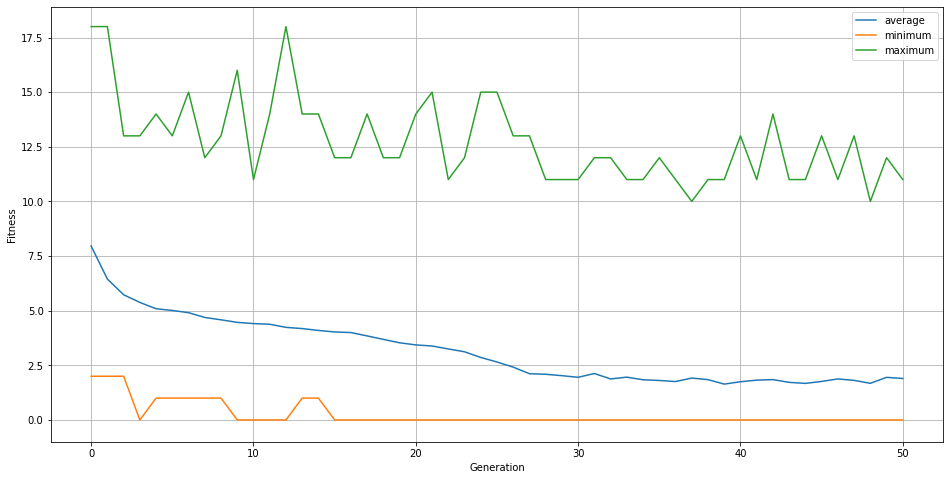

In [17]:
log, fittest_individual_r8 = evolution(
    individual_generator=lambda: random.choices(range(8), k=8),
    fitness_evaluation=evaluate_row_indexed_fitness,
    population_size=1000,
    generations=50,
    crossover_rate=.5,
    mutation_rate=.5,
    mutation_function=(tools.mutUniformInt, {"low": 0, "up": 8 - 1, "indpb": .25})
)
plot_generations(*log.select("gen", "avg", "min", "max"))

#### Fittest Individual

In [18]:
print(f"Positions: {fittest_individual_r8}")
print(f"Fitness: {abs(fittest_individual_r8.fitness.values[0])}")
display_row_grid(fittest_individual_r8)

Positions: [4, 0, 7, 3, 1, 6, 2, 5]
Fitness: 0.0


,0,1,2,3,4,5,6,7
0,,,,,👑,,,
1,👑,,,,,,,
2,,,,,,,,👑
3,,,,👑,,,,
4,,👑,,,,,,
5,,,,,,,👑,
6,,,👑,,,,,
7,,,,,,👑,,


### Evolutionary Algorithm on a 16x16 Board

#### Evolutionary Computation

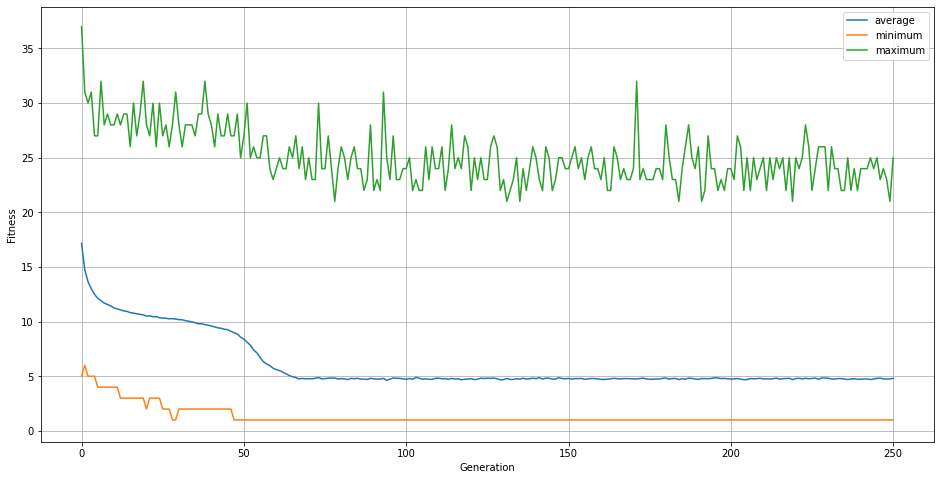

In [19]:
log, fittest_individual_r16 = evolution(
    individual_generator=lambda: random.choices(range(16), k=16),
    fitness_evaluation=evaluate_row_indexed_fitness,
    population_size=10000,
    generations=250,
    crossover_rate=.5,
    mutation_rate=.5,
    mutation_function=(tools.mutUniformInt, {"low": 0, "up": 16 - 1, "indpb": .25})
)
plot_generations(*log.select("gen", "avg", "min", "max"))

#### Fittest Individual

In [20]:
print(f"Positions: {fittest_individual_r16}")
print(f"Fitness: {abs(fittest_individual_r16.fitness.values[0])}")
display_row_grid(fittest_individual_r16)

Positions: [2, 13, 5, 2, 12, 14, 3, 8, 4, 15, 1, 11, 6, 0, 7, 10]
Fitness: 1.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,,,♕,,,,,,,,,,,,,
1,,,🟥,,,,,,,,,,,👑,,
2,,,🟥,,,👑,,,,,,,,,,
3,,,♕,,,,,,,,,,,,,
4,,,,,,,,,,,,,👑,,,
5,,,,,,,,,,,,,,,👑,
6,,,,👑,,,,,,,,,,,,
7,,,,,,,,,👑,,,,,,,
8,,,,,👑,,,,,,,,,,,
9,,,,,,,,,,,,,,,,👑


### Evolutionary Algorithm on a 32x32 Board

#### Evolutionary Computation

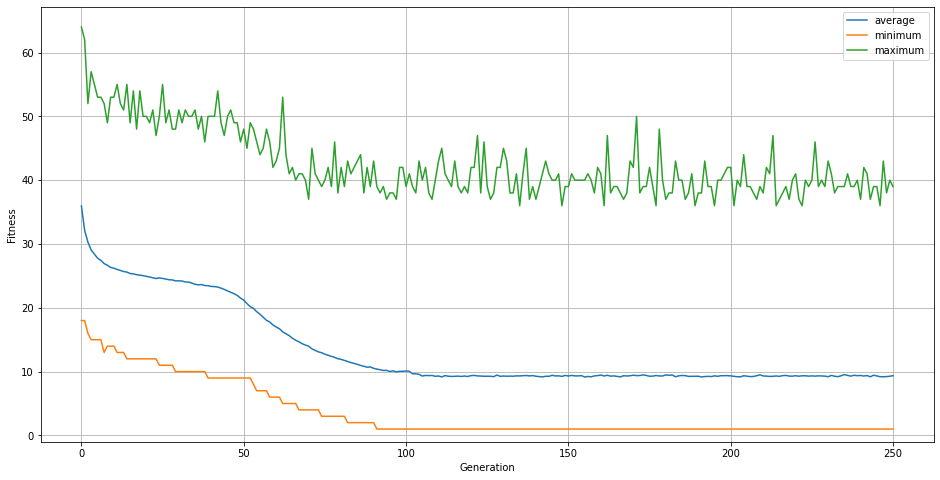

In [21]:
log, fittest_individual_r32 = evolution(
    individual_generator=lambda: random.choices(range(32), k=32),
    fitness_evaluation=evaluate_row_indexed_fitness,
    population_size=10000,
    generations=250,
    crossover_rate=.5,
    mutation_rate=.5,
    mutation_function=(tools.mutUniformInt, {"low": 0, "up": 32 - 1, "indpb": .25})
)
plot_generations(*log.select("gen", "avg", "min", "max"))

#### Fittest Individual

In [22]:
print(f"Positions: {fittest_individual_r32}")
print(f"Fitness: {abs(fittest_individual_r32.fitness.values[0])}")
display_row_grid(fittest_individual_r32)

Positions: [14, 17, 20, 16, 26, 8, 25, 27, 12, 15, 5, 0, 29, 4, 25, 11, 13, 10, 3, 24, 18, 21, 23, 2, 31, 19, 28, 1, 9, 6, 22, 30]
Fitness: 1.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,,,,,,,,,,,,,,,👑,,,,,,,,,,,,,,,,,
1,,,,,,,,,,,,,,,,,,👑,,,,,,,,,,,,,,
2,,,,,,,,,,,,,,,,,,,,,👑,,,,,,,,,,,
3,,,,,,,,,,,,,,,,,👑,,,,,,,,,,,,,,,
4,,,,,,,,,,,,,,,,,,,,,,,,,,,👑,,,,,
5,,,,,,,,,👑,,,,,,,,,,,,,,,,,,,,,,,
6,,,,,,,,,,,,,,,,,,,,,,,,,,♕,,,,,,
7,,,,,,,,,,,,,,,,,,,,,,,,,,🟥,,👑,,,,
8,,,,,,,,,,,,,👑,,,,,,,,,,,,,🟥,,,,,,
9,,,,,,,,,,,,,,,,👑,,,,,,,,,,🟥,,,,,,


<hr style="border-top: 2px solid #444">

## III. Conclusion